[View in Colaboratory](https://colab.research.google.com/github/divsinha99/Forecasting-Gold-Price/blob/master/ARIMA_Forecasting_Gold_Price.ipynb)

In [2]:
!pip install quandl

    100% |████████████████████████████████| 51kB 8.0MB/s 
    100% |████████████████████████████████| 61kB 7.5MB/s 
    100% |████████████████████████████████| 2.2MB 8.5MB/s 
    100% |████████████████████████████████| 430kB 14.8MB/s 
    100% |████████████████████████████████| 102kB 16.9MB/s 
    100% |████████████████████████████████| 256kB 12.7MB/s 
  Running setup.py bdist_wheel for inflection ... - done
  Stored in directory: /content/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
  Running setup.py bdist_wheel for pycparser ... - \ | done
  Stored in directory: /content/.cache/pip/wheels/c0/a1/27/5ba234bd77ea5a290cbf6d675259ec52293193467a12ef1f46
Successfully built inflection pycparser


In [0]:
import itertools
import numpy as np
import pandas as pd


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import TimeSeriesSplit

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sns.set_style('whitegrid')
sns.set_context('talk')



# Dickey Fuller test for Stationarity
def ad_fuller_test(ts):
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# Plot rolling stats for a time series
def plot_rolling_stats(ts):
    rolling_mean = ts.rolling(window=12,center=False).mean()
    rolling_std = ts.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
def plot_acf_pacf(series):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(series.squeeze(), lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(series, lags=40, ax=ax2)    
    

def auto_arima(param_max=1,series=pd.Series(),verbose=True):
    # Define the p, d and q parameters to take any value 
    # between 0 and param_max
    p = d = q = range(0, param_max+1)

    # Generate all different combinations of seasonal p, d and q triplets
    pdq = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]
    
    model_resuls = []
    best_model = {}
    min_aic = 10000000
    for param in pdq:
        try:
            mod = sm.tsa.ARIMA(series, order=param)

            results = mod.fit()
            
            if verbose:
                print('ARIMA{}- AIC:{}'.format(param, results.aic))
            model_resuls.append({'aic':results.aic,
                                 'params':param,
                                 'model_obj':results})
            if min_aic>results.aic:
                best_model={'aic':results.aic,
                            'params':param,
                            'model_obj':results}
                min_aic = results.aic
        except Exception as ex:
            print(ex)
    if verbose:
        print("Best Model params:{} AIC:{}".format(best_model['params'],
              best_model['aic']))  
        
    return best_model, model_resuls


def arima_gridsearch_cv(series, cv_splits=2,verbose=True,show_plots=True):
    # prepare train-test split object
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    
    # initialize variables
    splits = []
    best_models = []
    all_models = []
    i = 1
    
    # loop through each CV split
    for train_index, test_index in tscv.split(series):
        print("*"*20)
        print("Iteration {} of {}".format(i,cv_splits))
        i = i + 1
        
        # print train and test indices
        if verbose:
            print("TRAIN:", train_index, "TEST:", test_index)
        splits.append({'train':train_index,'test':test_index})
        
        # split train and test sets
        train_series = series.ix[train_index]
        test_series = series.ix[test_index]
        
        print("Train shape:{}, Test shape:{}".format(train_series.shape,
              test_series.shape))
        
        # perform auto arima
        _best_model, _all_models = auto_arima(series=train_series)
        best_models.append(_best_model)
        all_models.append(_all_models)
        
        # display summary for best fitting model
        if verbose:
            print(_best_model['model_obj'].summary())
        results = _best_model['model_obj']
        
        if show_plots:
            # show residual plots
            residuals = pd.DataFrame(results.resid)
            residuals.plot()
            plt.title('Residual Plot')
            plt.show()
            residuals.plot(kind='kde')
            plt.title('KDE Plot')
            plt.show()
            print(residuals.describe())
        
            # show forecast plot
            fig, ax = plt.subplots(figsize=(18, 4))
            fig.autofmt_xdate()
            ax = train_series.plot(ax=ax)
            test_series.plot(ax=ax)
            fig = results.plot_predict(test_series.index.min(), 
                                       test_series.index.max(), 
                                       dynamic=True,ax=ax,
                                       plot_insample=False)
            plt.title('Forecast Plot ')
            plt.legend()
            plt.show()

            # show error plot
            insample_fit = list(results.predict(train_series.index.min()+1, 
                                                train_series.index.max(),
                                                typ='levels')) 
            plt.plot((np.exp(train_series.ix[1:].tolist())-\
                             np.exp(insample_fit)))
            plt.title('Error Plot')
            plt.show()
    return {'cv_split_index':splits,
            'all_models':all_models,
            'best_models':best_models}
    
# results.predict(test_series.index.min(), test_series.index.max(),typ='levels')
def plot_on_original(train_series,test_series,forecast_series):
    # show forecast plot on original series
    fig, ax = plt.subplots(figsize=(18, 4))
    fig.autofmt_xdate()
    plt.plot(train_series,c='black')
    plt.plot(test_series,c='blue')
    plt.plot(np.exp(forecast_series),c='g')
    plt.title('Forecast Plot with Original Series')
    plt.legend()
    plt.show()    

In [0]:
import quandl
import warnings
import itertools
import numpy as np
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('talk')


from statsmodels.tsa.seasonal import seasonal_decompose


#Getting the Data

In [8]:
df = quandl.get("BUNDESBANK/BBK01_WT5511", end_date="2017-07-31")
print(df.shape)

new_df = df.reindex(pd.date_range(df.index.min(), 
                                  df.index.max(), 
                                  freq='D')).fillna(method='ffill')
print(new_df.shape)
#close_series = new_df.Close

(12152, 1)
(17550, 1)


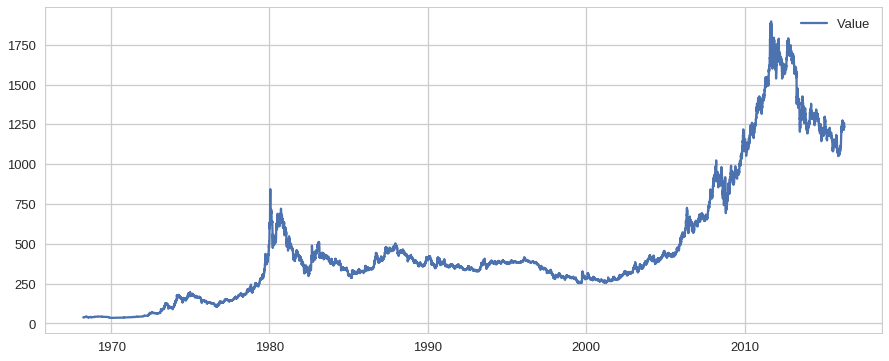

In [9]:
new_df.plot(figsize=(15, 6))
plt.show()

#Decompose

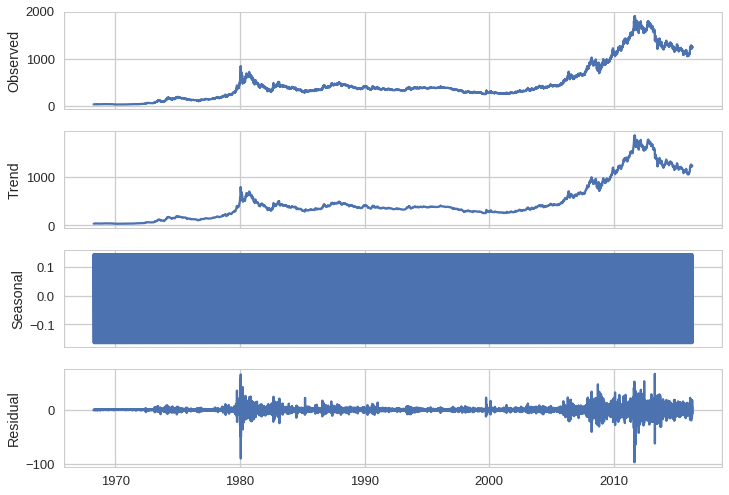

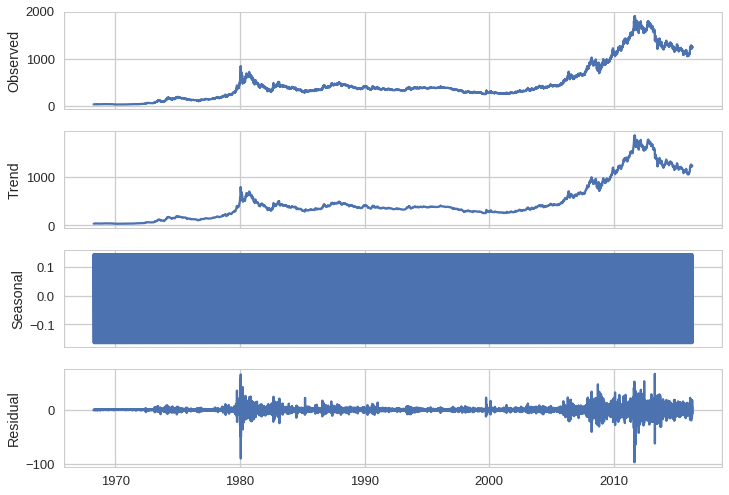

In [10]:
decompose = seasonal_decompose(new_df.Value.interpolate())
decompose.plot()

# Dickey Fuller Test

## Original Series

Test Statistic                    -0.364334
p-value                            0.915886
#Lags Used                        43.000000
Number of Observations Used    17506.000000
Critical Value (1%)               -3.430724
Critical Value (5%)               -2.861705
Critical Value (10%)              -2.566858
dtype: float64


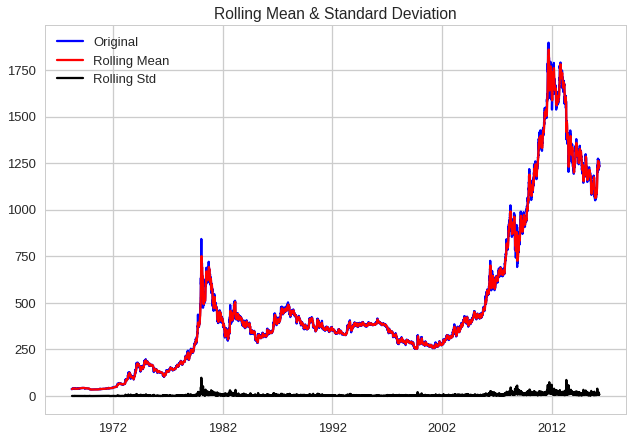

In [11]:
# Original Series
ad_fuller_test(new_df.Value)
plot_rolling_stats(new_df.Value)

## Log Series

Test Statistic                    -1.849748
p-value                            0.356057
#Lags Used                        29.000000
Number of Observations Used    17520.000000
Critical Value (1%)               -3.430723
Critical Value (5%)               -2.861705
Critical Value (10%)              -2.566858
dtype: float64


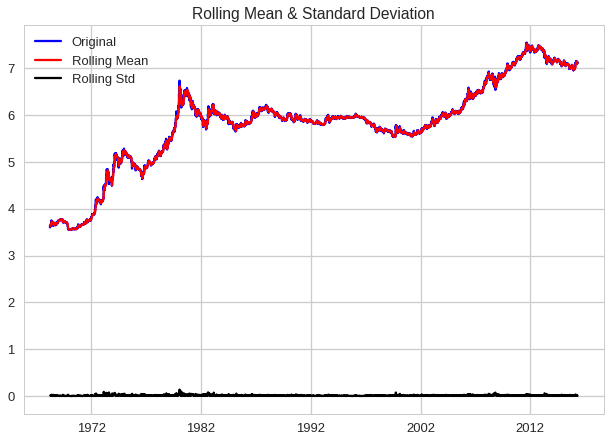

In [12]:
log_series = np.log(new_df.Value)

ad_fuller_test(log_series)
plot_rolling_stats(log_series)

## Log Difference

In [0]:
# Using log series with a shift to make it stationary
log_series_shift = log_series - log_series.shift()
log_series_shift = log_series_shift[~np.isnan(log_series_shift)]

Test Statistic                   -23.917175
p-value                            0.000000
#Lags Used                        28.000000
Number of Observations Used    17520.000000
Critical Value (1%)               -3.430723
Critical Value (5%)               -2.861705
Critical Value (10%)              -2.566858
dtype: float64


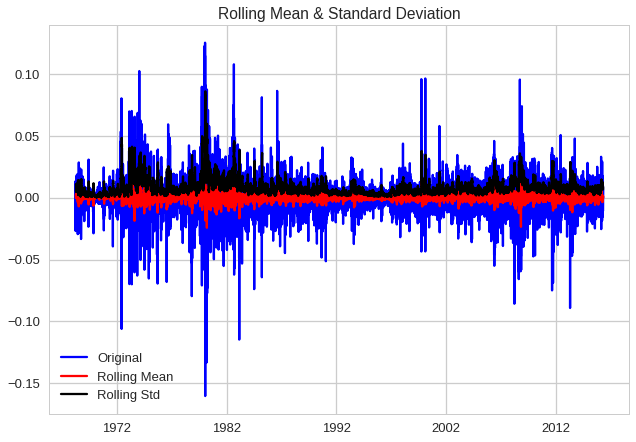

In [14]:
ad_fuller_test(log_series_shift)
plot_rolling_stats(log_series_shift)

## ACF/ PACF

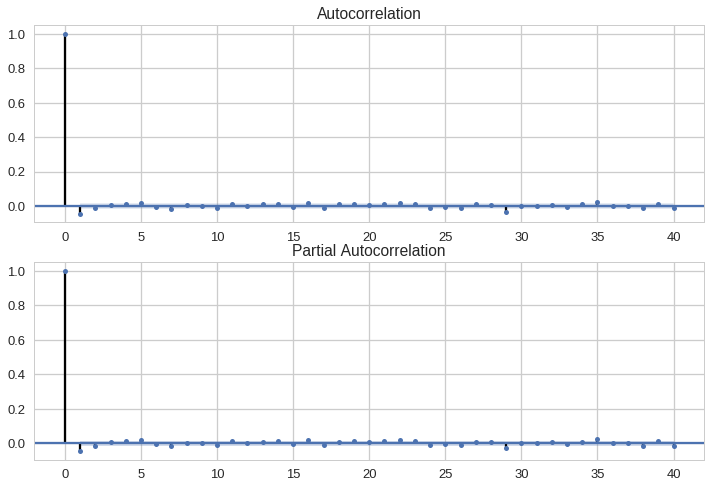

In [15]:
plot_acf_pacf(log_series_shift)

Log Differenced series seems stationary, same is visible through ACF and PACF plots

# ARIMA

In [0]:
new_df['log_series'] = log_series
new_df['log_series_shift'] = log_series_shift

## Training-Testing split:

********************
Iteration 1 of 5
TRAIN: [   0    1    2 ... 2922 2923 2924] TEST: [2925 2926 2927 ... 5847 5848 5849]
Train shape:(2925,), Test shape:(2925,)
ARIMA(0, 0, 0)- AIC:5358.675881541096


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


ARIMA(0, 0, 1)- AIC:1370.644173716004
ARIMA(0, 1, 0)- AIC:-17795.53995335306
ARIMA(0, 1, 1)- AIC:-17793.564973634646
ARIMA(1, 0, 0)- AIC:-17788.09838866874
ARIMA(1, 0, 1)- AIC:-17786.10419500788
ARIMA(1, 1, 0)- AIC:-17793.56214397539
ARIMA(1, 1, 1)- AIC:-17796.006063270484
Best Model params:(1, 1, 1) AIC:-17796.006063270484
                             ARIMA Model Results                              
Dep. Variable:           D.log_series   No. Observations:                 2924
Model:                 ARIMA(1, 1, 1)   Log Likelihood                8902.003
Method:                       css-mle   S.D. of innovations              0.012
Date:                Mon, 02 Jul 2018   AIC                         -17796.006
Time:                        20:19:03   BIC                         -17772.083
Sample:                    04-02-1968   HQIC                        -17787.390
                         - 04-03-1976                                         
                         coef    std err  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


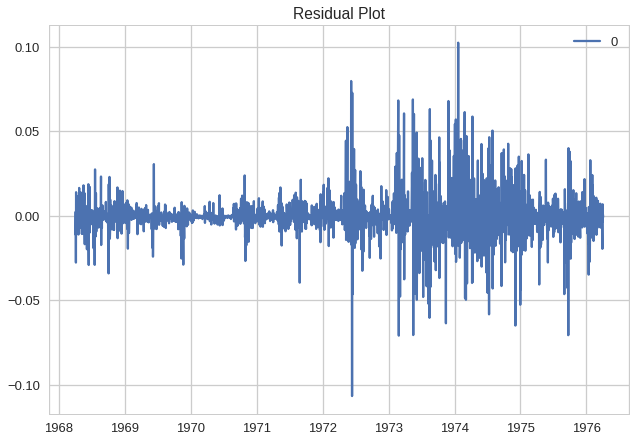

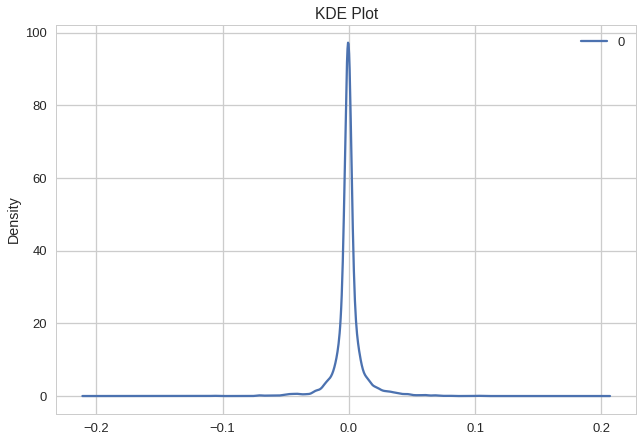

                  0
count  2.924000e+03
mean   1.884492e-07
std    1.152510e-02
min   -1.065016e-01
25%   -1.970484e-03
50%   -4.105381e-04
75%    1.345752e-03
max    1.024452e-01


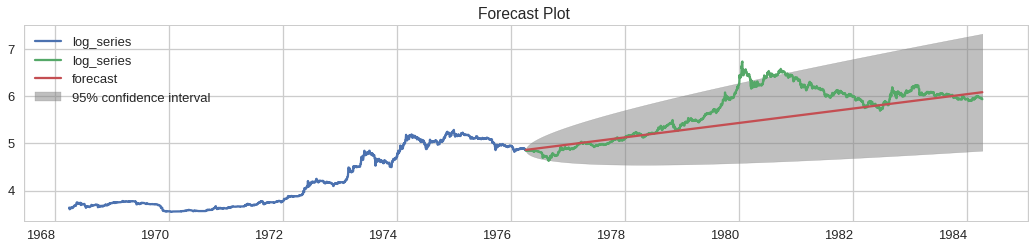

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:156: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


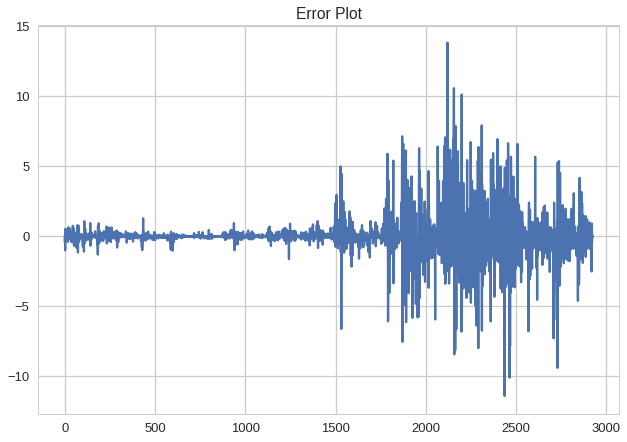

********************
Iteration 2 of 5
TRAIN: [   0    1    2 ... 5847 5848 5849] TEST: [5850 5851 5852 ... 8772 8773 8774]
Train shape:(5850,), Test shape:(2925,)
ARIMA(0, 0, 0)- AIC:15792.660349788817
ARIMA(0, 0, 1)- AIC:7814.097096459913
ARIMA(0, 1, 0)- AIC:-33512.28307448927
ARIMA(0, 1, 1)- AIC:-33516.96483490143
ARIMA(1, 0, 0)- AIC:-33502.698980690664
ARIMA(1, 0, 1)- AIC:-33507.0076841495
ARIMA(1, 1, 0)- AIC:-33516.56690977644


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:628: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:628: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:629: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:629: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


ARIMA(1, 1, 1)- AIC:-33517.287138258536
Best Model params:(1, 1, 1) AIC:-33517.287138258536
                             ARIMA Model Results                              
Dep. Variable:           D.log_series   No. Observations:                 5849
Model:                 ARIMA(1, 1, 1)   Log Likelihood               16762.644
Method:                       css-mle   S.D. of innovations              0.014
Date:                Mon, 02 Jul 2018   AIC                         -33517.287
Time:                        20:19:07   BIC                         -33490.591
Sample:                    04-02-1968   HQIC                        -33508.004
                         - 04-06-1984                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0004      0.000      2.310      0.021    5.96e-05       0.001
ar.L1.D.log_ser

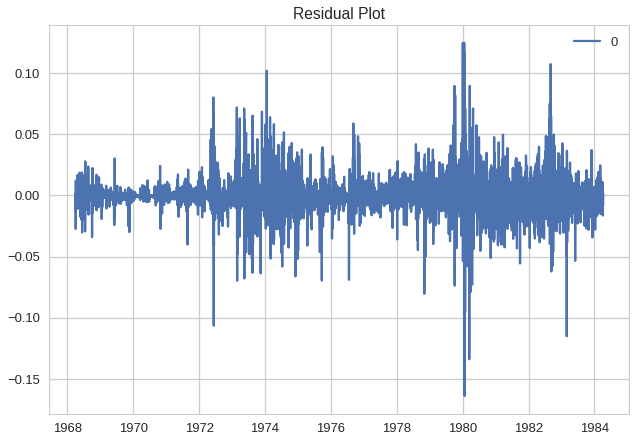

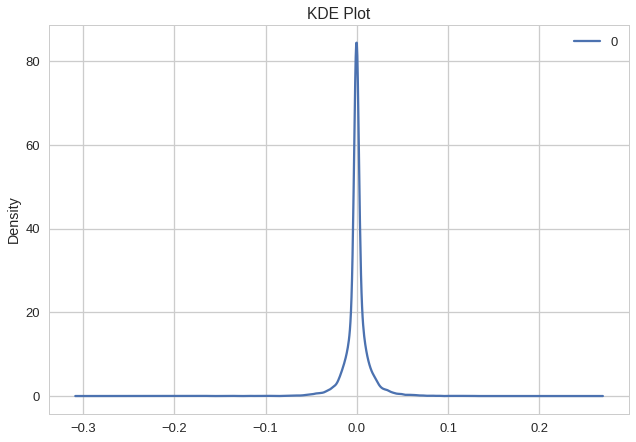

                  0
count  5.849000e+03
mean  -1.236007e-07
std    1.377704e-02
min   -1.640484e-01
25%   -2.716841e-03
50%   -4.121959e-04
75%    2.374837e-03
max    1.249847e-01


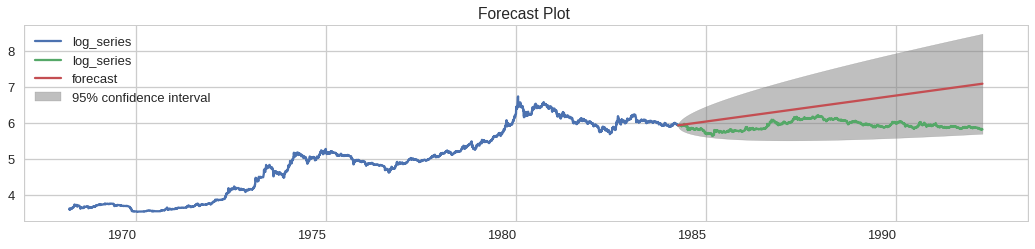

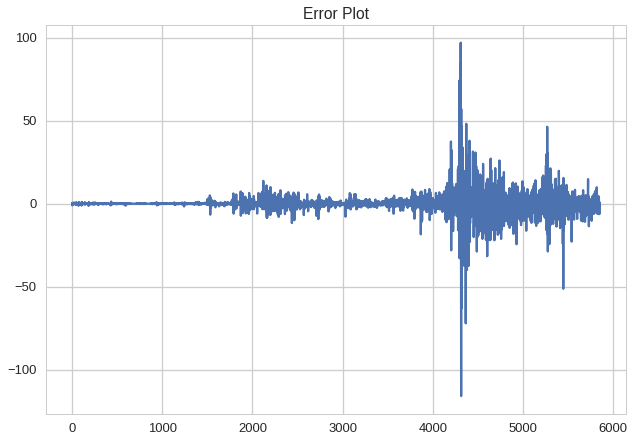

********************
Iteration 3 of 5
TRAIN: [   0    1    2 ... 8772 8773 8774] TEST: [ 8775  8776  8777 ... 11697 11698 11699]
Train shape:(8775,), Test shape:(2925,)
ARIMA(0, 0, 0)- AIC:22924.70092833443
ARIMA(0, 0, 1)- AIC:10939.92125625149
ARIMA(0, 1, 0)- AIC:-52348.46895881139
ARIMA(0, 1, 1)- AIC:-52365.88642216349
ARIMA(1, 0, 0)- AIC:-52340.1357071245
ARIMA(1, 0, 1)- AIC:-52357.136942691606
ARIMA(1, 1, 0)- AIC:-52364.9954035126
ARIMA(1, 1, 1)- AIC:-52366.21248652211
Best Model params:(1, 1, 1) AIC:-52366.21248652211
                             ARIMA Model Results                              
Dep. Variable:           D.log_series   No. Observations:                 8774
Model:                 ARIMA(1, 1, 1)   Log Likelihood               26187.106
Method:                       css-mle   S.D. of innovations              0.012
Date:                Mon, 02 Jul 2018   AIC                         -52366.212
Time:                        20:19:14   BIC                         -52337.8

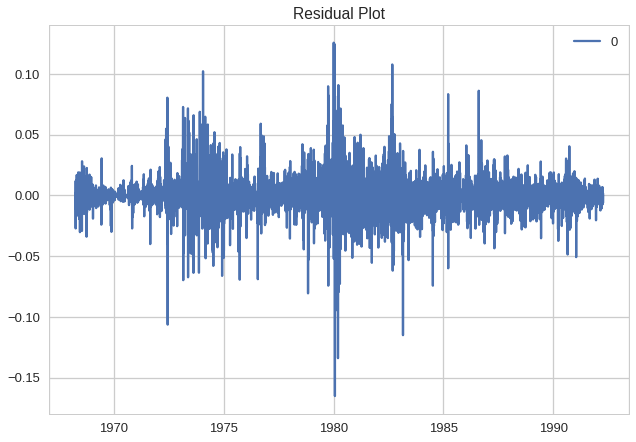

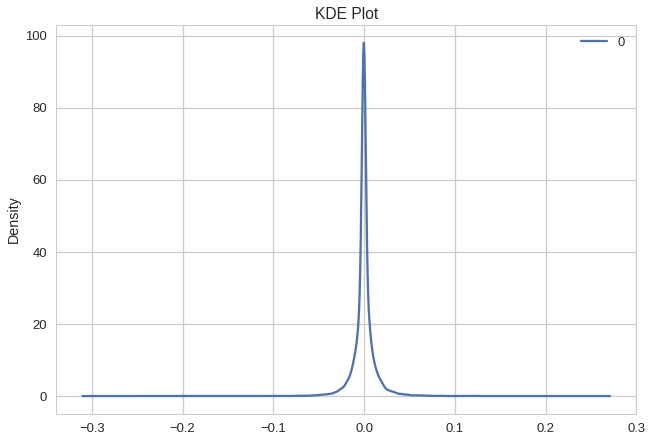

                  0
count  8.774000e+03
mean  -8.574714e-08
std    1.223435e-02
min   -1.650598e-01
25%   -2.567133e-03
50%   -2.630368e-04
75%    2.402582e-03
max    1.256747e-01


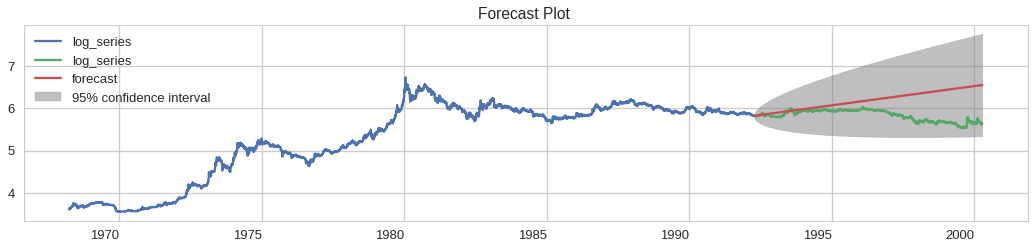

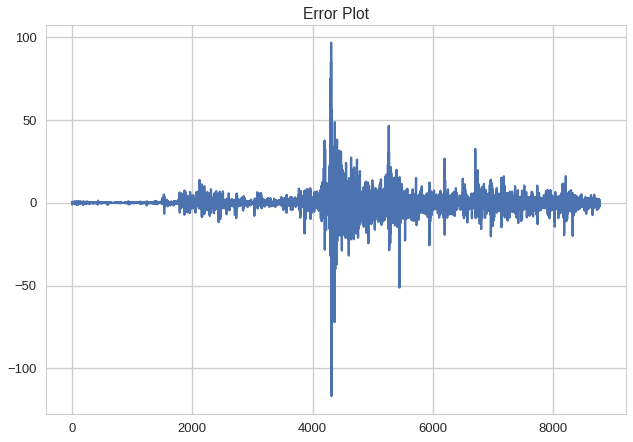

********************
Iteration 4 of 5
TRAIN: [    0     1     2 ... 11697 11698 11699] TEST: [11700 11701 11702 ... 14622 14623 14624]
Train shape:(11700,), Test shape:(2925,)
ARIMA(0, 0, 0)- AIC:28323.59324349887
ARIMA(0, 0, 1)- AIC:12343.352798126056
ARIMA(0, 1, 0)- AIC:-72092.36827299211
ARIMA(0, 1, 1)- AIC:-72119.8213792119
ARIMA(1, 0, 0)- AIC:-72085.08760853324
ARIMA(1, 0, 1)- AIC:-72112.1889304969
ARIMA(1, 1, 0)- AIC:-72118.75588542139
ARIMA(1, 1, 1)- AIC:-72119.86496019871
Best Model params:(1, 1, 1) AIC:-72119.86496019871
                             ARIMA Model Results                              
Dep. Variable:           D.log_series   No. Observations:                11699
Model:                 ARIMA(1, 1, 1)   Log Likelihood               36063.932
Method:                       css-mle   S.D. of innovations              0.011
Date:                Mon, 02 Jul 2018   AIC                         -72119.865
Time:                        20:19:23   BIC                         -

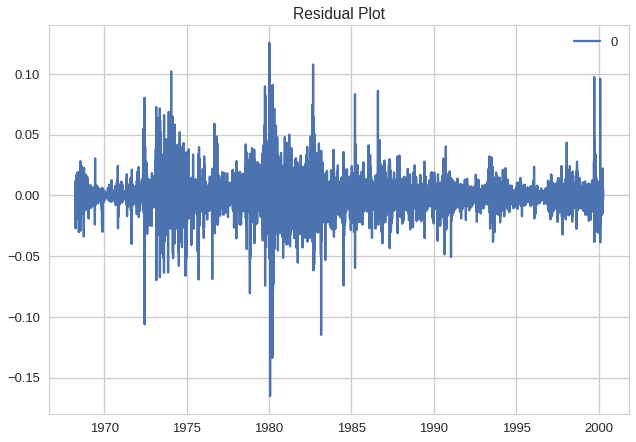

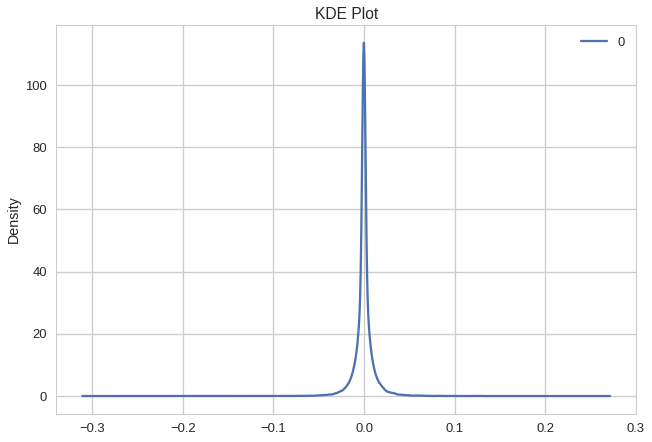

                  0
count  1.169900e+04
mean  -6.172759e-08
std    1.109183e-02
min   -1.652707e-01
25%   -2.322437e-03
50%   -1.811510e-04
75%    2.032709e-03
max    1.259057e-01


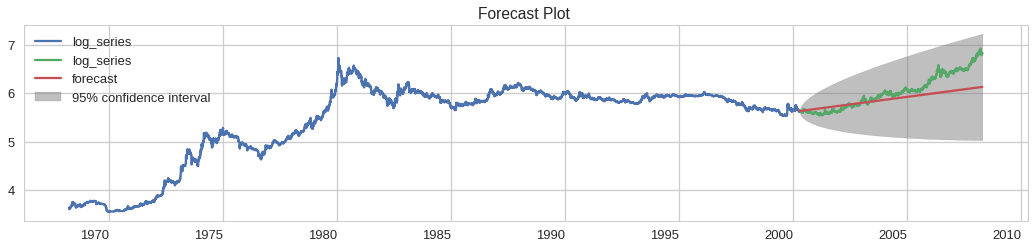

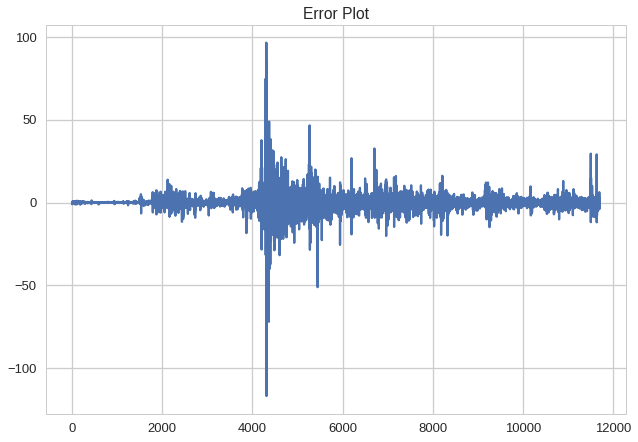

********************
Iteration 5 of 5
TRAIN: [    0     1     2 ... 14622 14623 14624] TEST: [14625 14626 14627 ... 17547 17548 17549]
Train shape:(14625,), Test shape:(2925,)
ARIMA(0, 0, 0)- AIC:34336.88986620506
ARIMA(0, 0, 1)- AIC:14355.652400376028
ARIMA(0, 1, 0)- AIC:-91312.7549609122


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)- AIC:-91348.77150649173
ARIMA(1, 0, 0)- AIC:-91301.1318476811
ARIMA(1, 0, 1)- AIC:-91336.41117978646
ARIMA(1, 1, 0)- AIC:-91347.65810577202
ARIMA(1, 1, 1)- AIC:-91348.29945380453
Best Model params:(0, 1, 1) AIC:-91348.77150649173
                             ARIMA Model Results                              
Dep. Variable:           D.log_series   No. Observations:                14624
Model:                 ARIMA(0, 1, 1)   Log Likelihood               45677.386
Method:                       css-mle   S.D. of innovations              0.011
Date:                Mon, 02 Jul 2018   AIC                         -91348.772
Time:                        20:19:36   BIC                         -91326.000
Sample:                    04-02-1968   HQIC                        -91341.207
                         - 04-15-2008                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

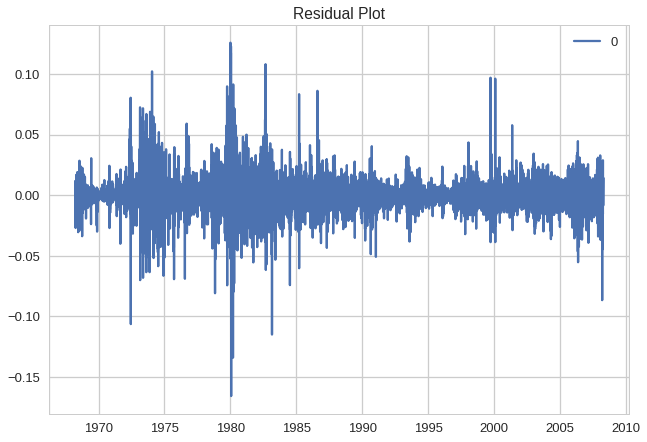

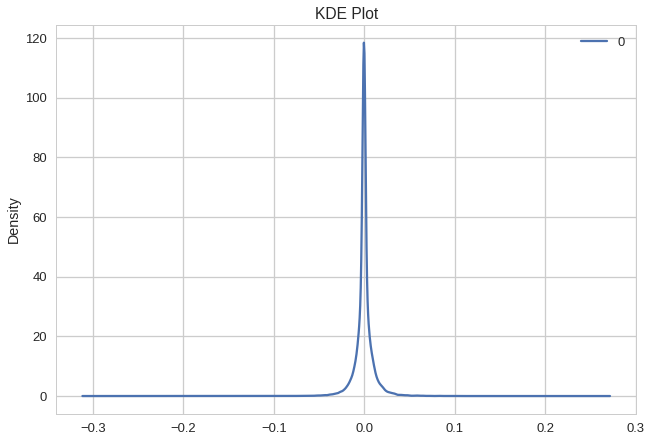

                  0
count  1.462400e+04
mean  -3.472696e-08
std    1.064827e-02
min   -1.656143e-01
25%   -2.387169e-03
50%   -2.301705e-04
75%    2.207817e-03
max    1.258538e-01


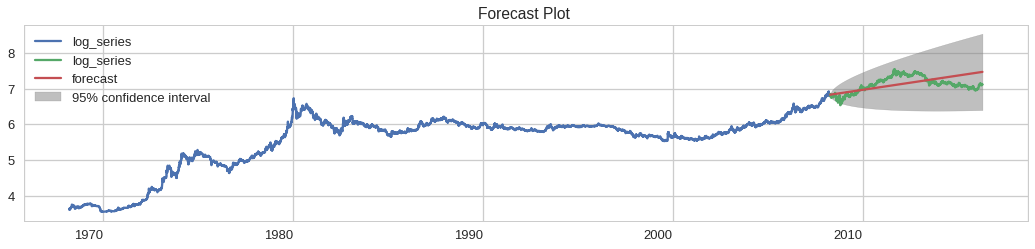

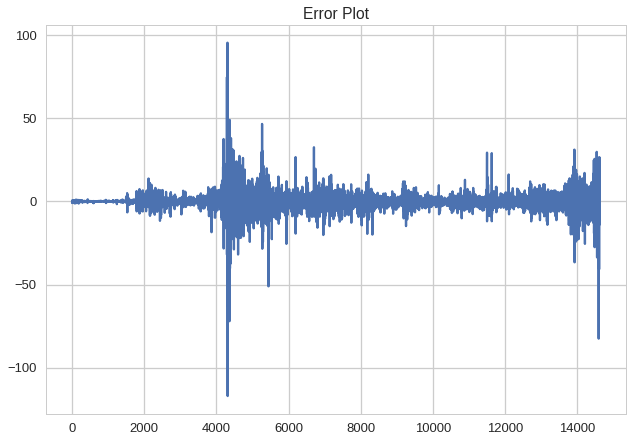

In [17]:
results_dict = arima_gridsearch_cv(new_df.log_series,cv_splits=5)